## 设计排序因子算法

1. 读取本地数据
2. 设计与添加算法
3. 可视化与获取因子信号数据
4. talib外部因子编写

## 1_读取本地数据

In [1]:
import numpy as np
from jaqs.data import DataView
from jaqs.research import SignalDigger
import warnings

warnings.filterwarnings("ignore")
dataview_folder = 'JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)
mask = dv.get_ts('mask_index_member')
can_enter = dv.get_ts('can_enter')
can_exit = dv.get_ts('can_exit')

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dataview loaded successfully.


## 2_设计与添加算法

StdDev(x,n)
Delay(x,n)
Delta(x,n)
Return(x,n,log)
Ts_Skewness(x,n)
Product(x,n)
Ts_Mean(x,n)

**1. 过去五天的平均成交量大于五天前的过去五天平均成交量变化率**


Ts_Mean(volume,5)/Delay(Ts_Mean(volume,5),5)

**2. 最低价的累积变化率上升**

Product(low/Delay(low,1),5) - 1

**3. 价格波动率上升**

StdDev(Return(close,1,True), 10)

**4. 收益率偏度**

Ts_Skewness(Return(low,5),5)

**5. 价量协方差**

Covariance(low, volume, 10)

In [2]:
dv.remove_field('Cov')

Field name [Cov] does not exist.


In [3]:
def add_factor():
    dv.add_formula('Volume_Up','Ts_Mean(volume,5)/Delay(Ts_Mean(volume,5),5)*-1*Return(close,5)',is_quarterly=False)    
    dv.add_formula('Low_Product','-1*Product(low/Delay(low,1),5) - 1',is_quarterly=False)
    dv.add_formula('STD', '-1*StdDev(Return(close,1), 10)', is_quarterly=False)
    dv.add_formula('Skewness', 'Ts_Skewness(Return(volume,5),5)', is_quarterly=False)
    dv.add_formula('Cov','-1*Covariance(low,volume,10)',is_quarterly=False)
add_factor()

In [4]:
dv.save_dataview('stockdata/hs300')


Store data...
Dataview has been successfully saved to:
C:\Users\small\OneDrive\notebook\Internet_Course\Selection\JAQS\stockdata\hs300

You can load it with load_dataview('C:\Users\small\OneDrive\notebook\Internet_Course\Selection\JAQS\stockdata\hs300')


## 3_可视化与获取因子信号数据

In [5]:
import matplotlib.pyplot as plt

def cal_obj(signal, name, period, quantile):
    price = dv.get_ts('close_adj')
    price_bench = dv.data_benchmark

    obj = SignalDigger(output_folder="hs300/%s" % name,
                       output_format='pdf')

    obj.process_signal_before_analysis(signal,
                                   price=price,
                                   n_quantiles=quantile, period=period,
                                   benchmark_price=price_bench,
                                   can_enter = can_enter,
                                   can_exit = can_exit,
                                   mask=mask
                                   )
    obj.create_full_report()
    return obj
    
def plot_pfm(signal, name, period=5, quantile=5):
    obj = cal_obj(signal, name, period, quantile)
    obj.fig_objs
    plt.show()
    
def signal_data(signal, name, period=5, quantile=5):
    obj = cal_obj(signal, name, period, quantile)
    return obj.signal_data

In [6]:
signal_dict = {'sig_1' : dv.get_ts('Volume_Up'),
               'sig_2' : dv.get_ts('Low_Product'),
               'sig_3' : dv.get_ts('STD'),
               'sig_4' : dv.get_ts('Skewness'),
               'sig_5' : dv.get_ts('Cov')}

In [7]:
data_signal = {key: signal_data(frame, key) for key, frame in signal_dict.items()}

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%


Value of signals of Different Quantiles Statistics
                   min           max          mean           std  count  \
quantile                                                                  
1        -4.448244e+16  1.895836e-01 -6.499444e+12  3.282543e+14  82946   
2        -3.929699e-01  2.325106e-01 -2.226987e-02  4.620945e-02  82360   
3        -2.352434e-01  2.659026e-01 -1.242107e-03  3.827854e-02  82350   
4        -1.652057e-01  3.359749e-01  1.508382e-02  3.799451e-02  82360   
5        -9.601820e-02  3.760106e+16  3.462099e+12  2.003023e+14  81770   

            count %  
quantile             
1         20.142987  
2         20.000680  
3         19.998252  
4         20.000680  
5         19.857402  
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\Selection\JAQS\hs300\sig_1\returns_report.pdf
Information Analysis
                ic
IC Mean      0.044
IC Std.      0.174
t-stat(I

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%


Value of signals of Different Quantiles Statistics
                   min           max          mean           std  count  \
quantile                                                                  
1        -8.818676e+08  6.625718e+05 -9.376437e+06  2.467965e+07  83288   
2        -8.217876e+07  1.246660e+07 -1.482240e+06  3.203704e+06  82691   
3        -5.520948e+07  2.433595e+07 -4.138087e+05  1.780147e+06  82685   
4        -1.401159e+07  4.165598e+07  2.652617e+05  2.253609e+06  82691   
5        -2.725820e+06  1.762297e+09  5.196908e+06  2.913466e+07  82117   

            count %  
quantile             
1         20.143565  
2         19.999178  
3         19.997727  
4         19.999178  
5         19.860353  
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\Selection\JAQS\hs300\sig_5\returns_report.pdf
Information Analysis
                ic
IC Mean      0.042
IC Std.      0.138
t-stat(I

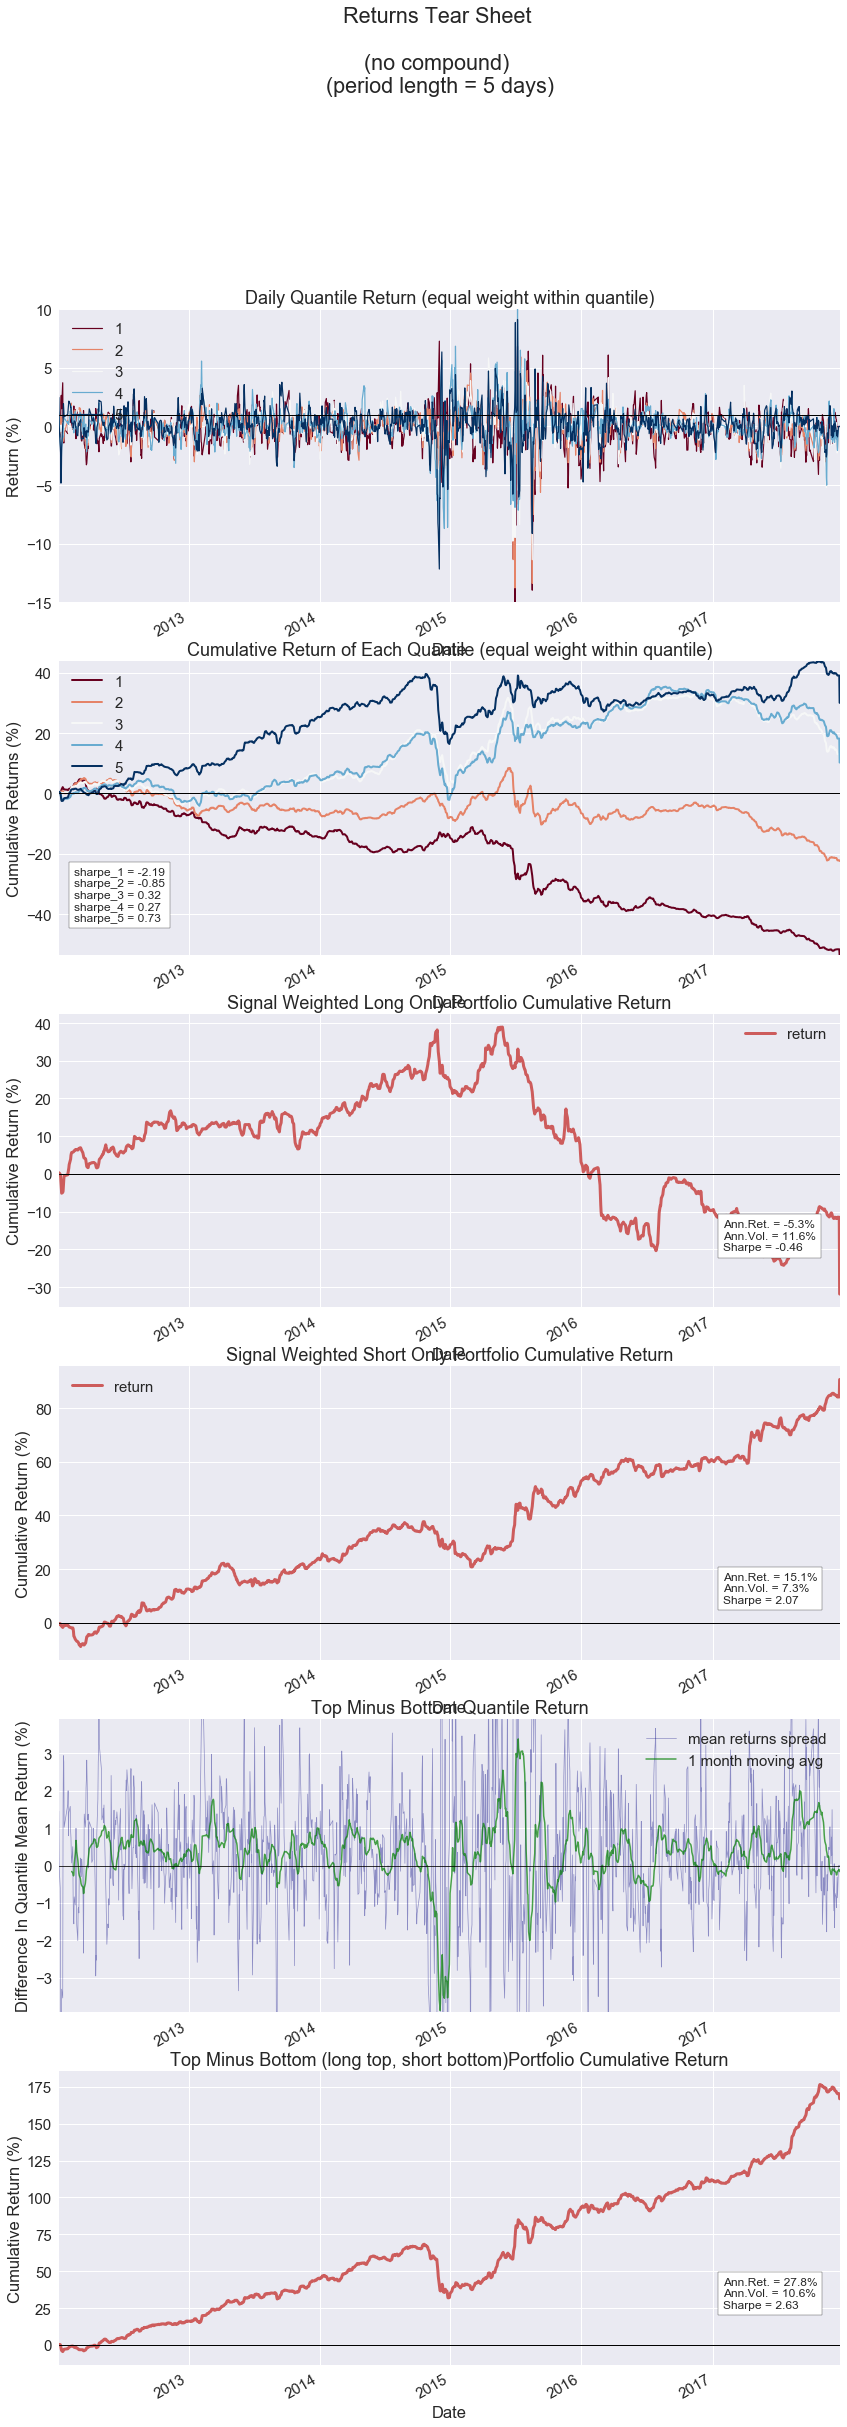

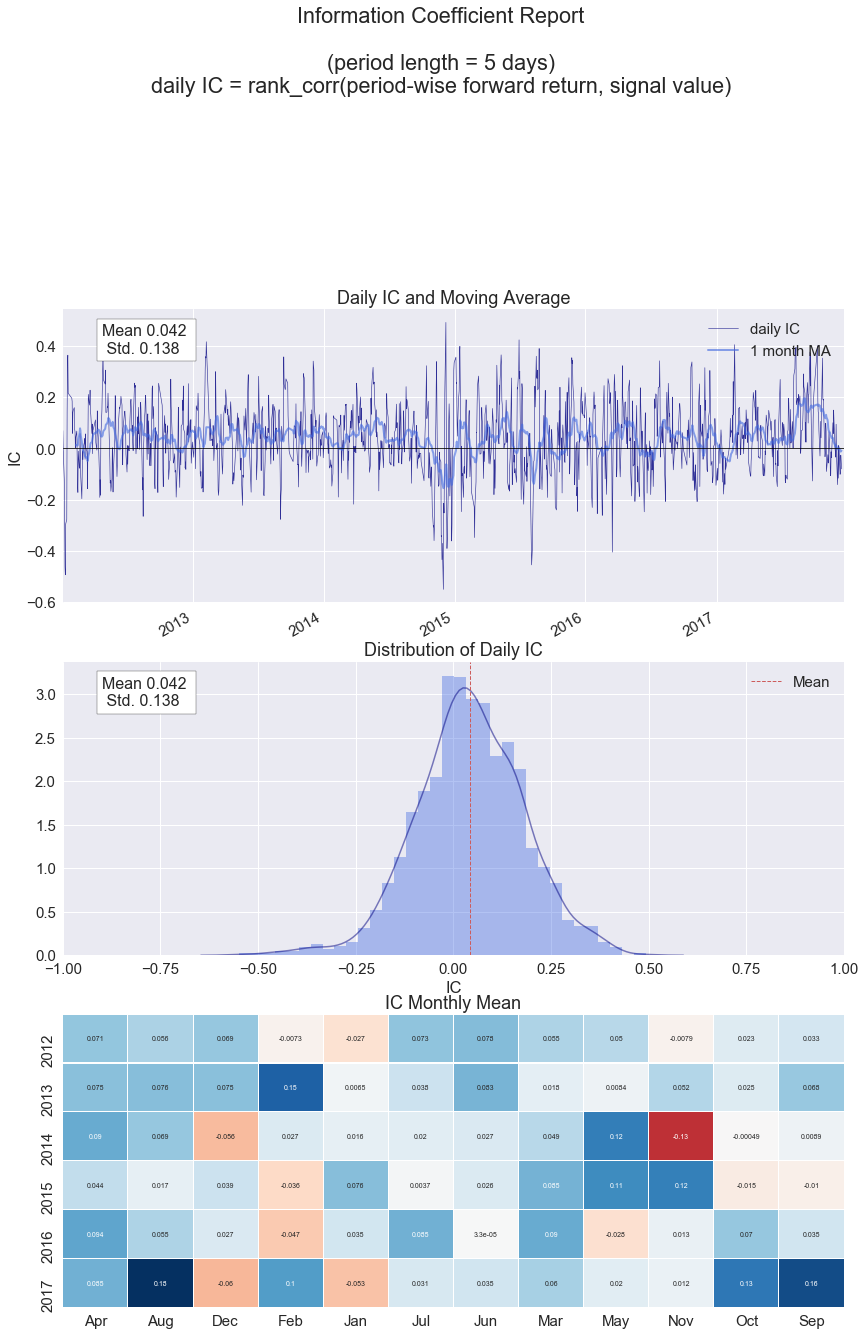

In [9]:
plot_pfm(signal_dict.get('sig_5'), 'sig_5')

## 4_talib外部因子编写

In [10]:
import talib as ta
import pandas as pd

close_adj = dv.get_ts('close_adj')
close = close_adj.dropna(how='all', axis=1)
slope_df = pd.DataFrame({name: -ta.LINEARREG_SLOPE(value.values, 3) for name, value in close.iteritems()}, index=close.index)

In [11]:
dv.remove_field('slope')

Field name [slope] does not exist.


In [12]:
dv.append_df(slope_df,'slope')

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%


Value of signals of Different Quantiles Statistics
                min        max      mean       std  count    count %
quantile                                                            
1        -57.788764   0.924510 -0.807342  1.487646  83172  20.143327
2         -3.229754   1.582843 -0.109449  0.256158  82577  19.999225
3         -1.875339   2.531553  0.012089  0.219972  82570  19.997530
4         -1.387552   4.972311  0.131095  0.322812  82577  19.999225
5         -0.757552  51.460955  0.739474  1.514192  82005  19.860693
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\Selection\JAQS\hs300\slope\returns_report.pdf
Information Analysis
                ic
IC Mean      0.045
IC Std.      0.162
t-stat(IC)     NaN
p-value(IC)    NaN
IC Skew        NaN
IC Kurtosis    NaN
Ann. IR      0.278
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\Selection\JAQS\hs300\slope\information_report.p

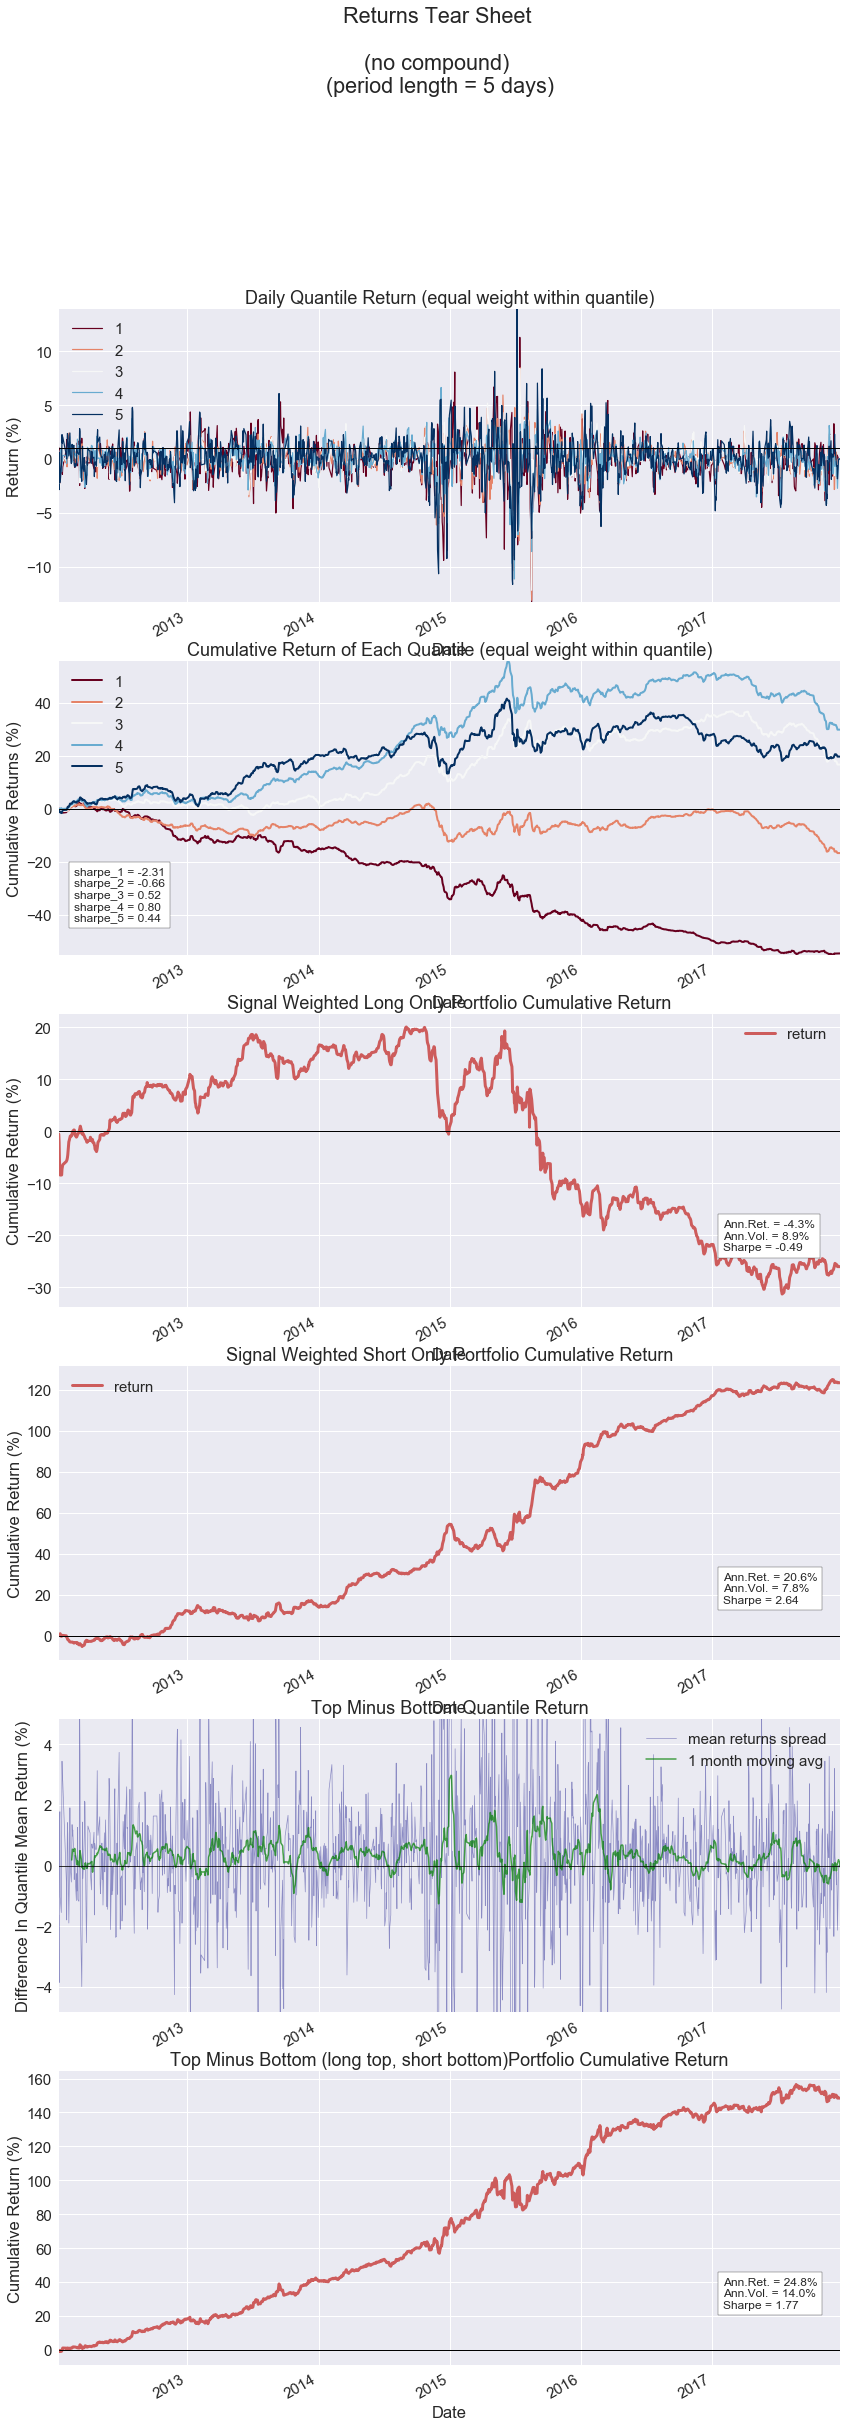

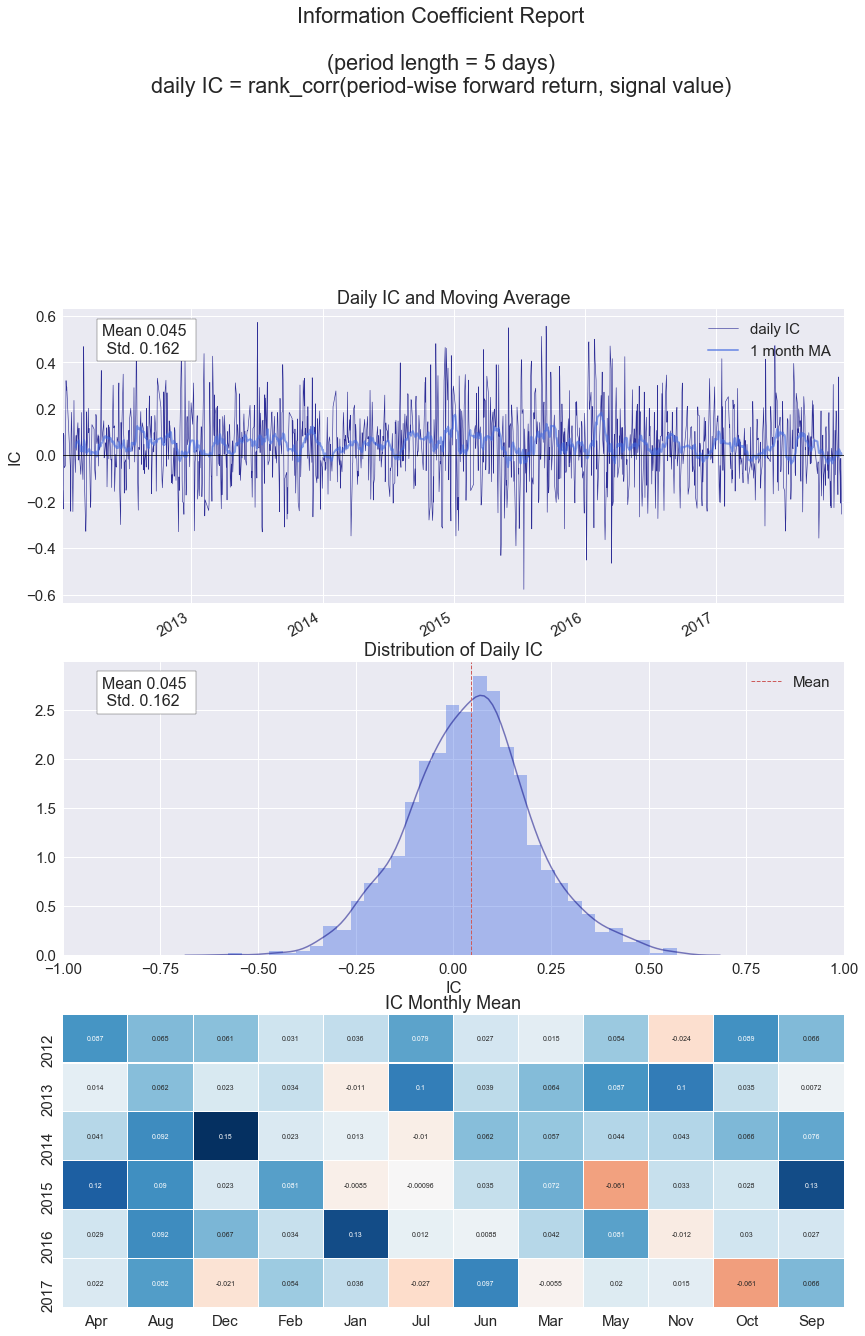

In [13]:
plot_pfm(dv.get_ts('slope'), 'slope')

In [14]:
dv.save_dataview('stockdata/hs300')


Store data...
Dataview has been successfully saved to:
C:\Users\small\OneDrive\notebook\Internet_Course\Selection\JAQS\stockdata\hs300

You can load it with load_dataview('C:\Users\small\OneDrive\notebook\Internet_Course\Selection\JAQS\stockdata\hs300')
